In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from attrs import define
from abc import ABC, abstractmethod
from math import sqrt, atan2, hypot, sin, cos, pi, log
from typing import Optional, Tuple, List
from scipy.interpolate import griddata

In [2]:
from test_generator import Line, generate_image, apply_general_noise
from polarization import MaxComponentInertionPolarization, InertionPolarization, PolarizationMethod
from line_utils import abc2natural, natural2abc, draw_abc, draw_r_phi
from experiment import run_exp, ExperimentData
from cell import Cell


In [3]:
def is_same(a, b, eps = 1e-3, w=[1e-3, 1]):
    assert(len(a) == len(b) == len(w))
    result = 0
    for i in range(len(a)):
        result += w[i] * abs(a[i] - b[i])
    return result < eps

In [4]:
"""
Testing line conversions
"""

assert(is_same(abc2natural(natural2abc((150, 0))), (150, 0)))
assert(is_same(abc2natural(natural2abc((150, 1))), (150, 1)))
assert(is_same(abc2natural(natural2abc((150, 3))), (150, 3)))
assert(is_same(abc2natural(natural2abc((150, 5))), (150, 5)))


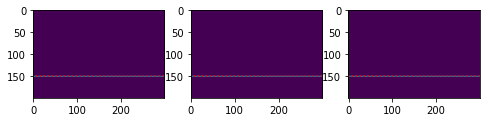

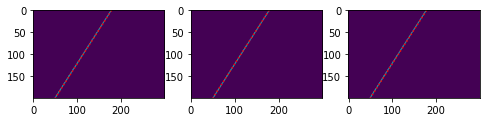

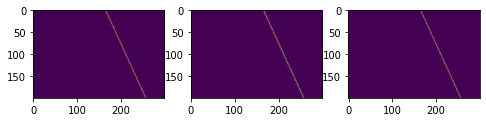

/home/derrior/HSE/Diploma/src/line_utils.py:42: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, F, [0], alpha=max(1, intensity), **default_parameters)


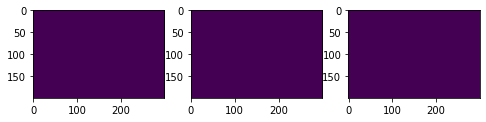

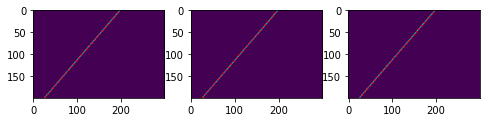

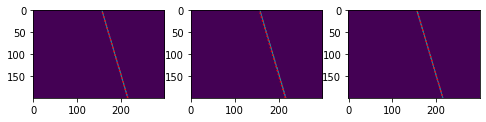

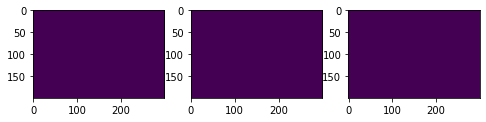

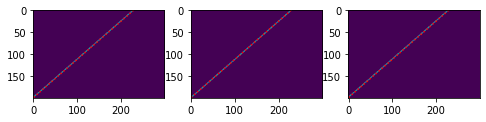

In [5]:
def test_draw(r, phi):
    plt.figure(figsize=(8, 5))
    plt.subplot(131)
    img = 255 - generate_image([Line(r, phi, 1, 0)])
    plt.imshow(img)
    abc = natural2abc((r, phi))
    draw_abc(abc)
    plt.subplot(132)

    plt.imshow(img)
    draw_r_phi((r, phi))
    plt.subplot(133)    
    plt.imshow(img)
    draw_r_phi(abc2natural(abc))
    plt.show()

test_draw(150, 0)
test_draw(150, 1)
test_draw(150, 2)
test_draw(150, 3)
test_draw(-150, 4)
test_draw(-150, 5)
test_draw(-150, 6)
test_draw(150, 7)

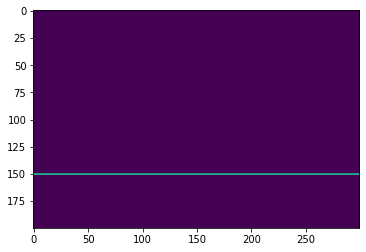

(150.0, 6.283185307179586)


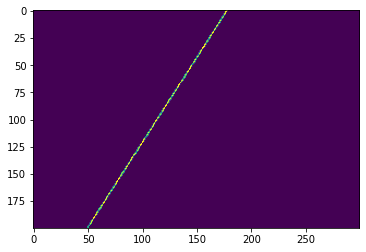

(149.30619953174147, 1.0002027199642518)


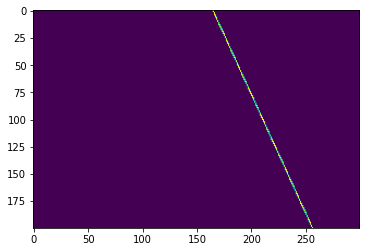

(149.75508826325654, 1.9999843039331007)


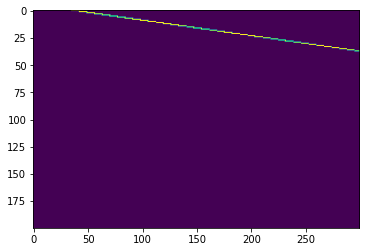

(5.41060068299645, 3.000075636646555)


In [6]:
"""
Testing polarization detection
"""
def test_one_line(r, phi, method: PolarizationMethod):
    img = 255 - generate_image([Line(r, phi, 1, 0)])
    plt.imshow(img)
    plt.show()
    cell = Cell(0, img.shape[0], 0, img.shape[1], img)
    result = method(cell)
    print(result)
    assert(is_same(result, (r, phi)))

test_one_line(150, 2 * pi, InertionPolarization())
test_one_line(150, 1, InertionPolarization())
test_one_line(150, 2, InertionPolarization())
test_one_line(5, 3, InertionPolarization())


(0.5403023058681398, 0.8414709848078965, -150)
(-0.5, 299.5)


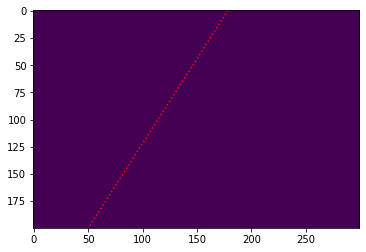

In [7]:
img = generate_image([])
print(natural2abc((150, 1)))
plt.imshow(img)
print(plt.gca().get_xlim())
draw_r_phi((150, 1))

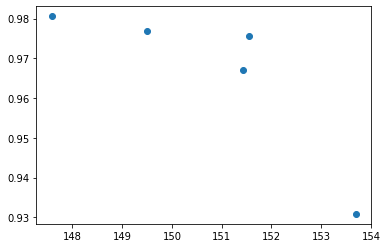

total


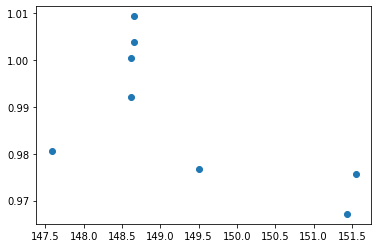

total


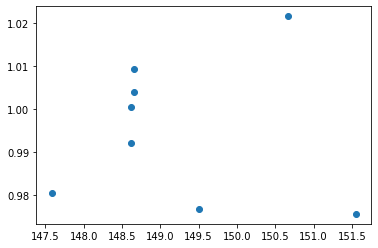

total


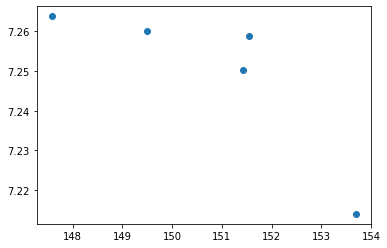

total


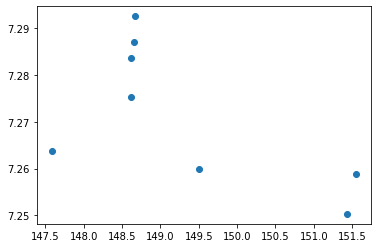

total


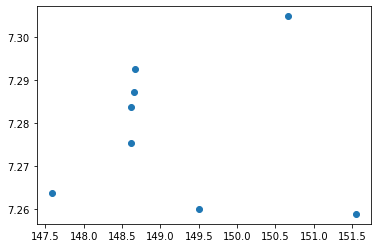

total


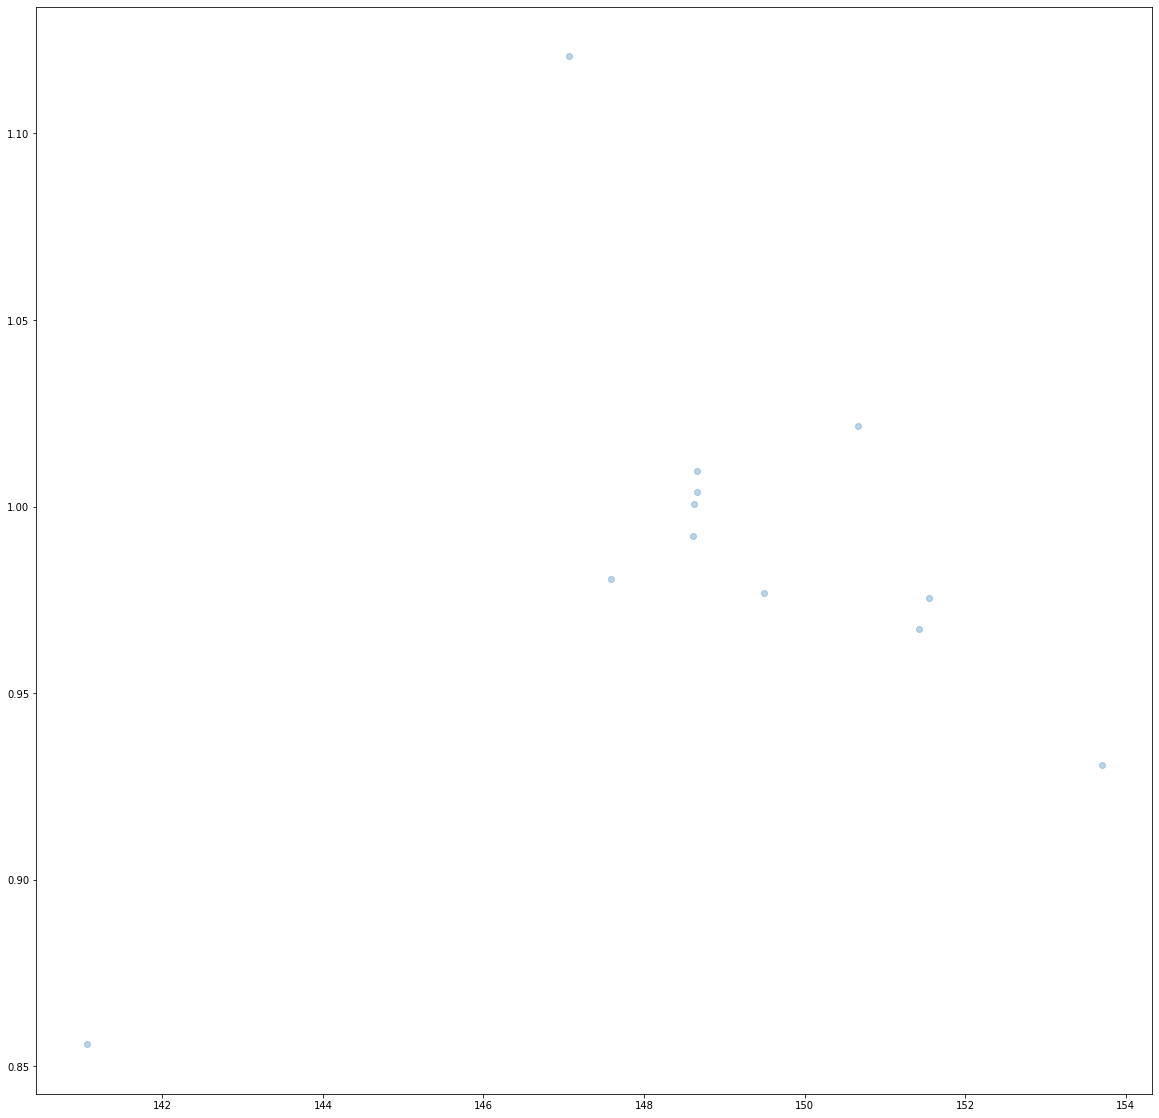

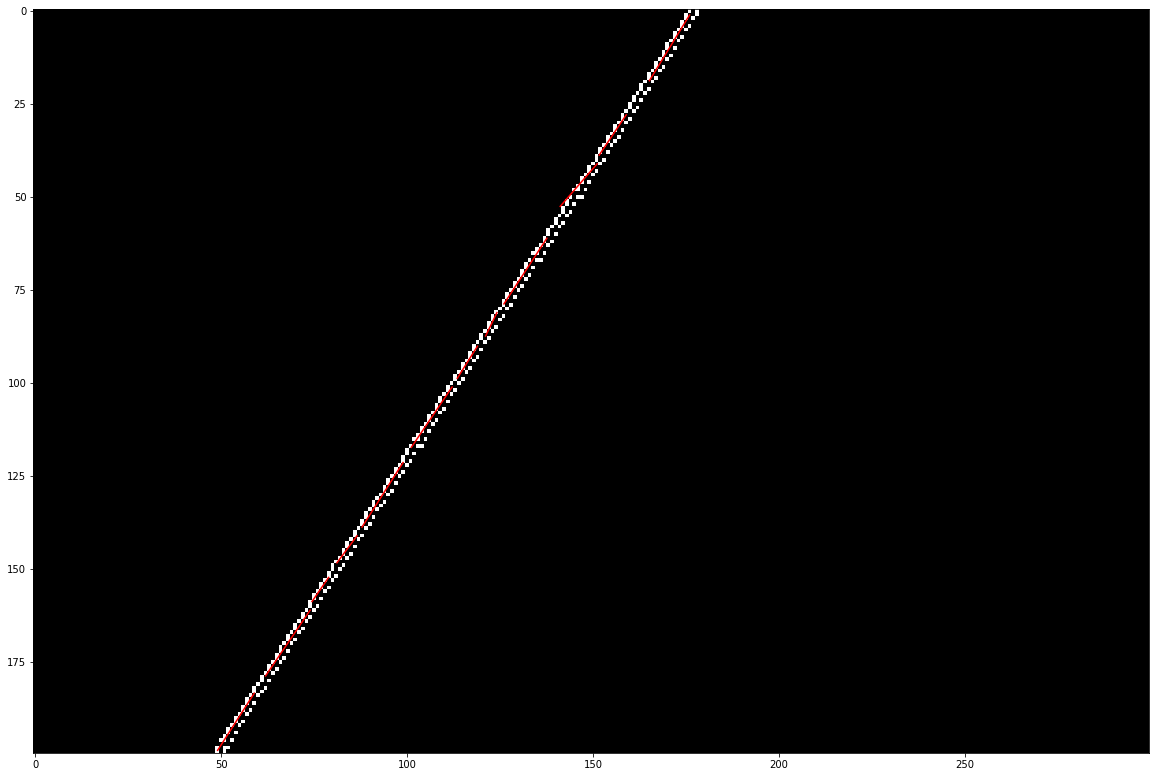

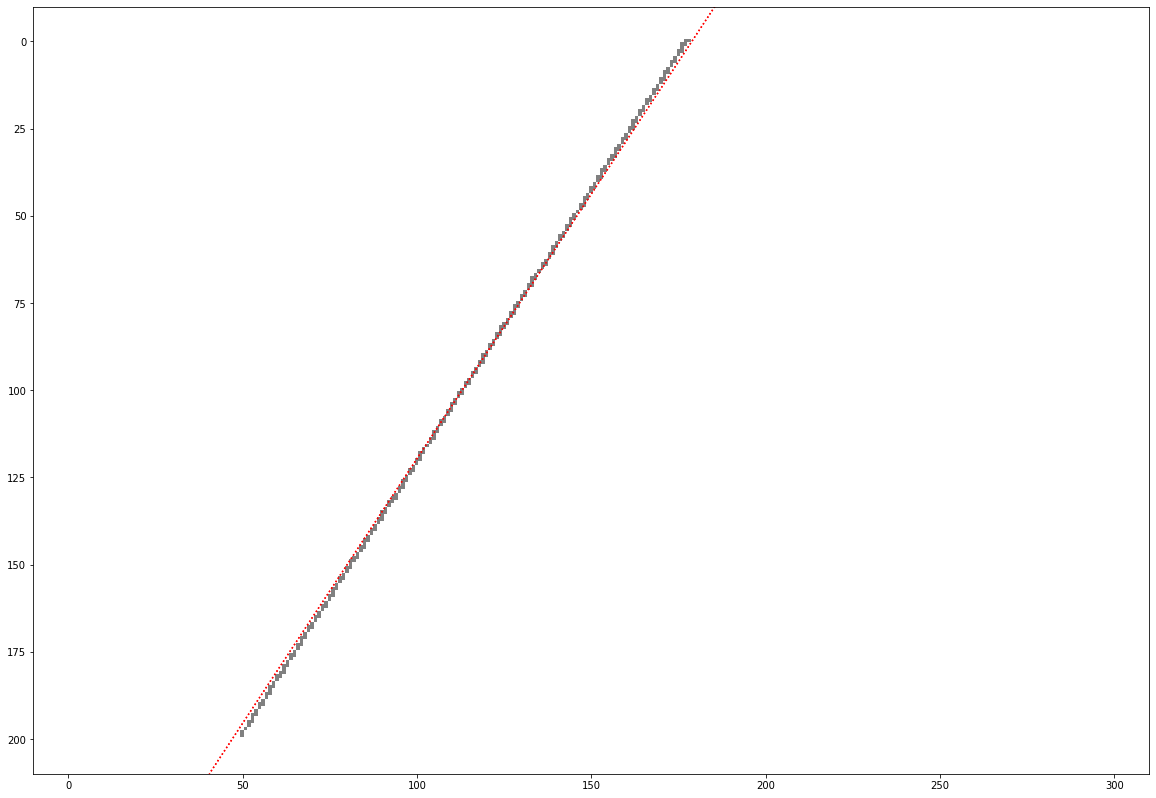

In [8]:
"""
Testing line detection
"""
def test_one_line(r, phi):
    img = generate_image([Line(r, phi, 1, 0)])
    edge = 255 - img
    exp_data = run_exp(img, polarization_method=MaxComponentInertionPolarization(11))
    exp_data.visualize(compact=False)
    
test_one_line(150, 1)

In [9]:
np.linalg.eig(np.array(
[
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
]))

(array([ 1., -1.,  1.]),
 array([[ 0.70710678, -0.70710678,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

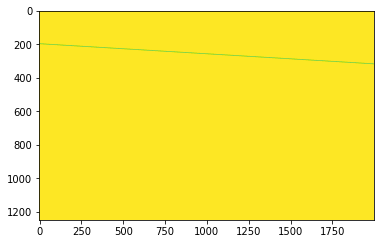

In [10]:
img = generate_image([Line(200, -0.06, 1, 0)], h=1250, w=2000)
plt.imshow(img)